<div style="text-align:center">

<h2> Assignment/Lab 5: Winter 2025 </h2>
<h2> Convolutional Neural Networks (CNNs)</h2>

</div>

---

<h2>I. Team members</h2>
<b>
    
- Minh Le Nguyen
- Liam Knapp
- Gautam Singh
- Gleb Ignatov

</b>
<br>

---

## II. Objectives
- Understand Convolutional Neural Networks (CNNs) and demonstrate how they can be used for image
classification.
- Implement CNNs using TensorFlow and Keras.
- Explore the importance of convolutional layers, pooling layers, and fully connected layers in building effective
image classifiers.
- Compare the performance of Fully Connected Neural Networks (FNN) and Convolutional Neural Networks
(CNN) for handwritten digit classification.
- Evaluate the performance of FNN and CNN models on noisy images.
- Gain hands-on experience with TensorFlow and Keras.

Add impulsive noise (randomly occurring white and black pixels) to some of the test samples, and use
these noisy images to test the performance of both the FNN and CNN models. You can write your own
function to add impulsive noise to the images. Alternatively, a function has already been provided for you in
the course shell.

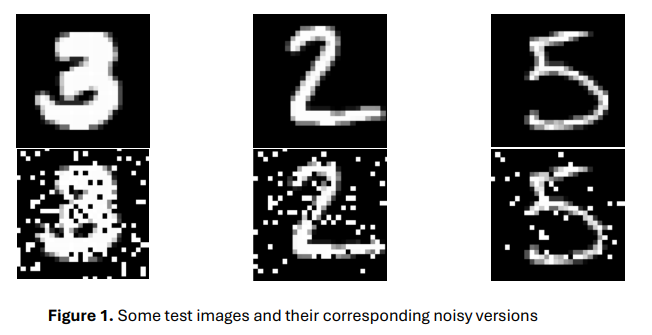

In [40]:
import os
import torch
import numpy as np
import pandas as pd
from torch import nn
torch.manual_seed(42)
from tqdm import tqdm
import tensorflow as tf
from pathlib import Path
from tensorflow import keras
from datetime import datetime
from torchinfo import summary
from torchviz import make_dot
import matplotlib.pyplot as plt
from torchmetrics import Accuracy
from tensorflow.keras import layers
from IPython.display import display, Image
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split
os.environ["PATH"] += os.pathsep + './Graphviz-12.2.1/bin'
from torch.utils.data import TensorDataset, DataLoader, random_split

## III. Fully Connected Neural Networks (FNN) 

### Step 1: Dataset Exploration and Preprocessing

#### Load the MNIST dataset using TensorFlow:

In [41]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

#### Normalize the pixel values of the images to a range of [0, 1]

In [42]:
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype( "float32") / 255.0

#### Visualize a few sample images from the dataset using Matplotlib.

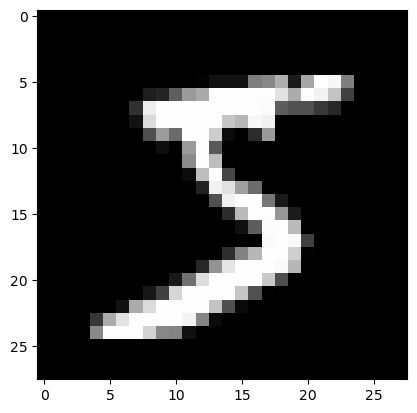

In [43]:
plt.imshow(x_train[0], cmap='gray')
plt.show()

#### Reshape the input images for the FNN. For the FNN, reshape the images to a 1D vector:

In [44]:
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

#### Custom Noise Function

In [45]:
def add_impulsive_noise(image, noise_factor=0.1):
    np.random.seed(42)
    noisy_image = image.copy()

    white_pixels = np.random.rand(*image.shape) < (noise_factor / 2)
    noisy_image[white_pixels] = 1

    black_pixels = np.random.rand(*image.shape) < (noise_factor / 2)
    noisy_image[black_pixels] = 0

    return noisy_image

In [46]:
x_train, x_val, y_train, y_val = train_test_split(
    x_train, 
    y_train, 
    test_size=0.2,
    random_state=42
)
x_test_noisy = np.array([add_impulsive_noise(img.reshape(28, 28)).reshape(-1) 
                        for img in x_test])

### Step 2: Fully Connected Neural Network (FNN) Mode

#### Implement an FNN with 2 hidden layers, using ReLU activations, followed by a softmax output layer.

In [47]:
#Reference: https://keras.io/guides/sequential_model/

# Create the FNN model
FNNmodel = keras.Sequential(
    [
        keras.Input(shape=(784,)), # Input layer (28 * 28 = 784)
        layers.Dense(128, activation='relu'), # First hidden layer with 128 units
        layers.Dense(64, activation='relu'), # Second hidden layer with 64 units
        layers.Dense(10, activation='softmax', name="output_layer") # Output layer with 10 units (one for each digit)
    ]
)

#### FNN Model Summary

In [48]:
FNNmodel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 128)               100480    
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 output_layer (Dense)        (None, 10)                650       
                                                                 
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


#### Compile and Build the FNN Model

In [49]:
# Compile the model
FNNmodel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model (10 epochs)
history = FNNmodel.fit(
    x_train, 
    y_train, 
    epochs=10,
    validation_data=(x_val, y_val),
    batch_size=32
)
training_history = history.history
output = FNNmodel.predict(x_train[:1])

print(output)

Epoch 1/10
1500/1500 [==============================] - 9s 6ms/step - loss: 0.2638 - accuracy: 0.9225 - val_loss: 0.1427 - val_accuracy: 0.9546
Epoch 2/10
1500/1500 [==============================] - 7s 4ms/step - loss: 0.1121 - accuracy: 0.9659 - val_loss: 0.1095 - val_accuracy: 0.9672
Epoch 3/10
1500/1500 [==============================] - 8s 6ms/step - loss: 0.0781 - accuracy: 0.9756 - val_loss: 0.0918 - val_accuracy: 0.9714
Epoch 4/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.0585 - accuracy: 0.9817 - val_loss: 0.0862 - val_accuracy: 0.9751
Epoch 5/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.0463 - accuracy: 0.9849 - val_loss: 0.0926 - val_accuracy: 0.9739
Epoch 6/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.0356 - accuracy: 0.9882 - val_loss: 0.0920 - val_accuracy: 0.9753
Epoch 7/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.0293 - accuracy: 0.9907 - val_loss: 0.0918 - val_accuracy:

#### Collect lists of metrics when training FNN (Per Epoch)

In [50]:
train_accuracy = training_history['accuracy']      
train_loss = training_history['loss']             
val_accuracy = training_history['val_accuracy']    
val_loss = training_history['val_loss']           

### Step 3: Model Evaluation 

#### Evaluate the FNN model on the standard test data and record the performance metrics

In [51]:
# Evaluate on original test data
test_loss, test_accuracy = FNNmodel.evaluate(x_test, y_test)
print(f"\nOriginal Test Data Results:")
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

313/313 [==============================] - 2s 5ms/step - loss: 0.1054 - accuracy: 0.9749

Original Test Data Results:
Test Loss: 0.10540153831243515
Test Accuracy: 0.9749000072479248


#### Visualize the Loss and Accuracy through the training, validating and test process on the Standard Test Dataset

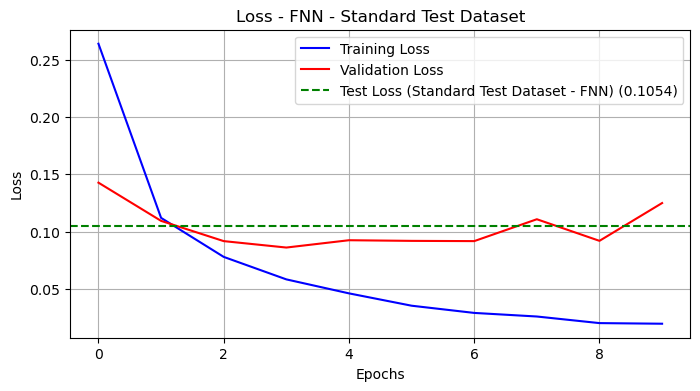

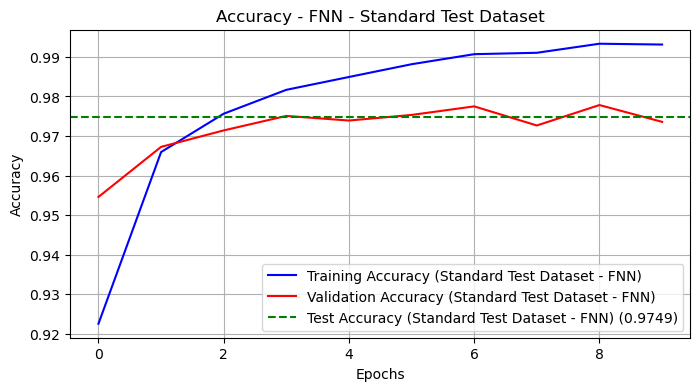

In [52]:
epochs = range(len(train_loss))

plt.figure(figsize=(8, 4))
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.axhline(y=test_loss, color='g', linestyle='--', label=f'Test Loss (Standard Test Dataset - FNN) ({test_loss:.4f})')
plt.title('Loss - FNN - Standard Test Dataset')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(epochs, train_accuracy, 'b-', label='Training Accuracy (Standard Test Dataset - FNN)')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy (Standard Test Dataset - FNN)')
plt.axhline(y=test_accuracy, color='g', linestyle='--', label=f'Test Accuracy (Standard Test Dataset - FNN) ({test_accuracy:.4f})')
plt.title('Accuracy - FNN - Standard Test Dataset')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

#### Add impulsive noise to a selected number of test images (choose a number and specify it in your report), then evaluate the FNN model on the noisy test data and record the performance metrics.

In [53]:
# Evaluate on noisy test data
noisy_test_loss, noisy_test_accuracy = FNNmodel.evaluate(x_test_noisy, y_test)
print(f"\nNoisy Test Data Results:")
print(f"Noisy Test Loss: {noisy_test_loss}")
print(f"Noisy Test Accuracy: {noisy_test_accuracy}")

313/313 [==============================] - 1s 5ms/step - loss: 0.3220 - accuracy: 0.9157

Noisy Test Data Results:
Noisy Test Loss: 0.32199445366859436
Noisy Test Accuracy: 0.9157000184059143


#### Visualize the Loss and Accuracy through the training, validating and test process on the Noisy Test Dataset

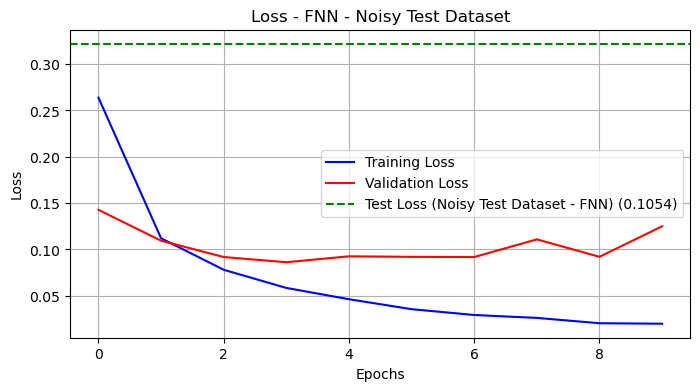

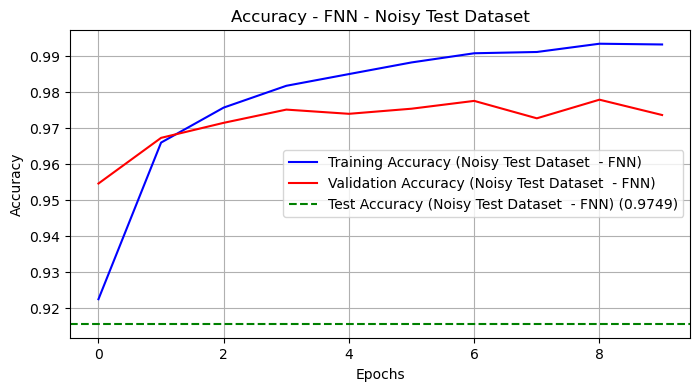

In [54]:
plt.figure(figsize=(8, 4))
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.axhline(y=noisy_test_loss, color='g', linestyle='--', label=f'Test Loss (Noisy Test Dataset - FNN) ({test_loss:.4f})')
plt.title('Loss - FNN - Noisy Test Dataset')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(epochs, train_accuracy, 'b-', label='Training Accuracy (Noisy Test Dataset  - FNN)')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy (Noisy Test Dataset  - FNN)')
plt.axhline(y=noisy_test_accuracy, color='g', linestyle='--', label=f'Test Accuracy (Noisy Test Dataset  - FNN) ({test_accuracy:.4f})')
plt.title('Accuracy - FNN - Noisy Test Dataset')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [55]:
sample_idx = 0
original_pred = FNNmodel.predict(x_test[sample_idx:sample_idx+1])
noisy_pred = FNNmodel.predict(x_test_noisy[sample_idx:sample_idx+1])

print(f"\nPrediction for original test sample {sample_idx}:")
print(original_pred)
print(f"Prediction for noisy test sample {sample_idx}:")
print(noisy_pred)
print(f"True label: {y_test[sample_idx]}")

1/1 [==============================] - 0s 13ms/step

Prediction for original test sample 0:
[[1.2396494e-11 4.2802177e-12 5.5408922e-09 3.6169939e-10 7.0744230e-11
  4.4952417e-11 5.8704858e-19 1.0000000e+00 2.0906650e-11 1.1131397e-09]]
Prediction for noisy test sample 0:
[[1.8616824e-07 6.8797199e-09 1.7363483e-05 9.3384477e-07 1.9824631e-09
  1.2211943e-06 2.1265598e-13 9.9998033e-01 4.5669154e-08 9.8951451e-09]]
True label: 7


---

## IV. Convolutional Neural Network (CNN) 

### Step 4: Dataset Exploration and Preprocessing
MNIST dataset preparation and analysis: Dataset => Analyze → Transform → Split into Train/Val/Test → Dataloader

In [56]:
# !pip install torch torchvision torchaudio
# !pip install torchmetrics
# !pip install torchinfo
# !pip install torchviz

In [57]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

C:\Users\ignat\AppData\Local\Temp\ipykernel_30592\4253117385.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('gray_r')


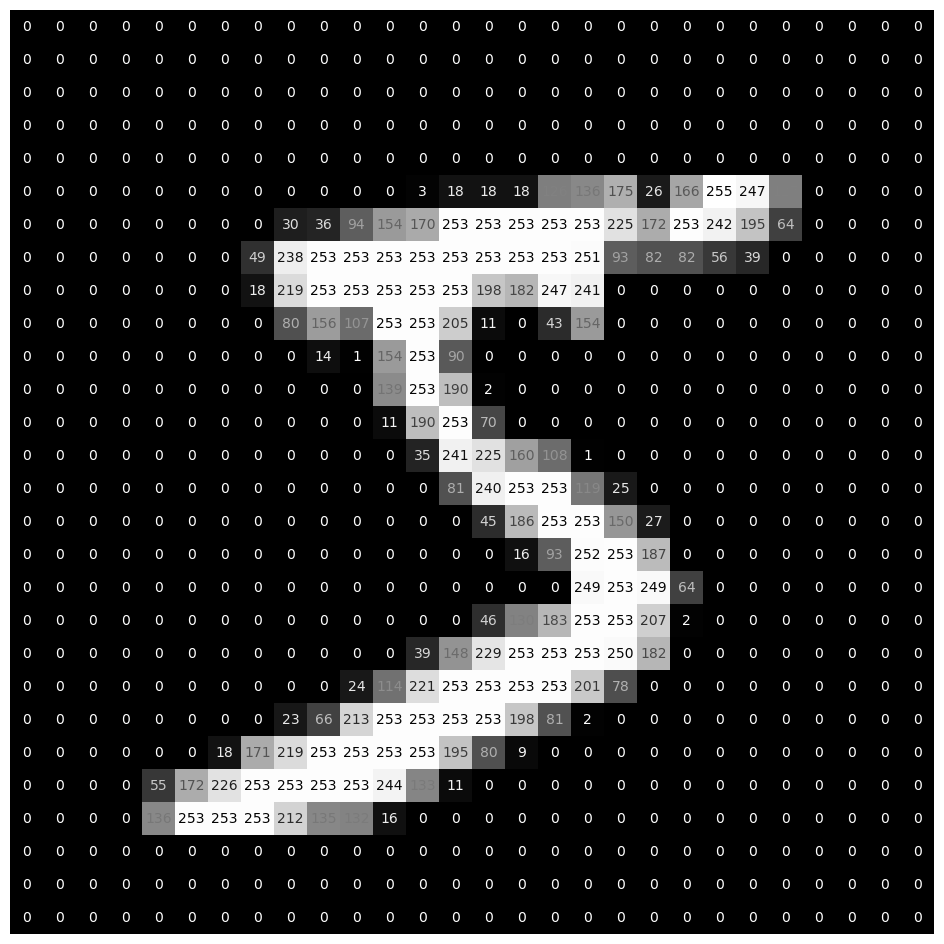

In [58]:
def img_pixel_superimpose(img, ax):
    w, h = img.shape
    color_map = plt.cm.get_cmap('gray_r')
    ax.imshow(img, cmap='gray')
    for x in range(w):
        for y in range(h):
            color = color_map(img[x][y])
            ax.annotate(str(img[x][y]), xy=(y,x), horizontalalignment='center', verticalalignment='center',
                        color=color)
            plt.axis(False)

fig = plt.figure(figsize = (12,12)) 
ax0 = fig.add_subplot(1, 1, 1)
rand_ind = torch.randint(0, len(x_train), size=[1]).item()
img0 = x_train[0]
img_pixel_superimpose(img0, ax0)

#### Plot 20 random images from x_train

C:\Users\ignat\AppData\Local\Temp\ipykernel_30592\1118007782.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


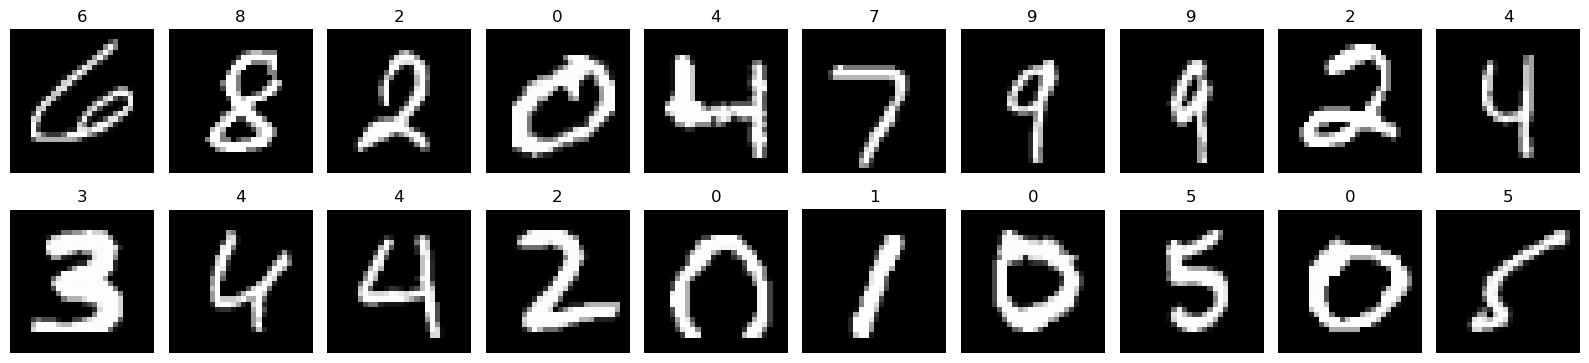

In [59]:
fig = plt.figure(figsize=(16, 4))
rows, cols = 2, 10

for i in range(1, (rows*cols) + 1):
    rand_ind = torch.randint(0, len(x_train), size=[1]).item()
    img = x_train[rand_ind]
    label = y_train[rand_ind]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img, cmap='gray')
    plt.title(f"{label}")
    plt.axis(False)
    plt.tight_layout()

#### Normalize the pixel values of the images to a range of [0, 1]

In [60]:
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype( "float32") / 255.0
x_train = x_train[:, None, :, :]
x_test = x_test[:, None, :, :]

#### Convert To Pytorch Tensor, Correct the data type and Calculate the mean and std

In [61]:
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
x_test_np = x_test_tensor.numpy()
x_test_noisy_np = np.array([add_impulsive_noise(img) for img in x_test_np])
x_test_noisy_reshaped = x_test_noisy_np.reshape(-1, 28, 28)

mean = x_train_tensor.mean()
std = x_train_tensor.std()
mean, std

(tensor(0.1307), tensor(0.3081))

#### Plot 20 random images from x_test_noisy

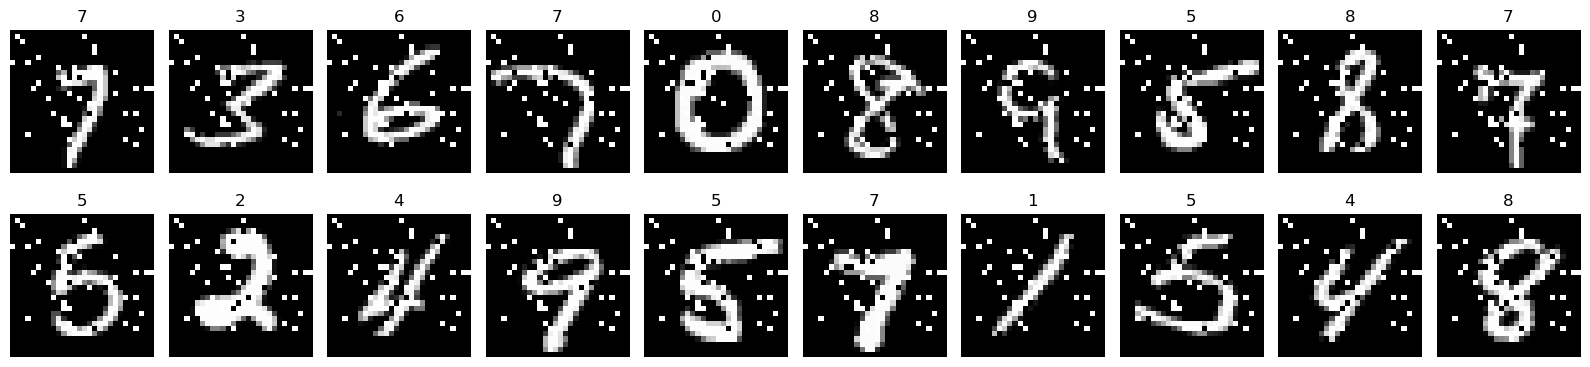

In [62]:
fig = plt.figure(figsize=(16, 4))
rows, cols = 2, 10
for i in range(1, (rows * cols) + 1):
    rand_ind = np.random.randint(0, len(x_test_noisy_reshaped))
    img = x_test_noisy_reshaped[rand_ind]
    label = y_test[rand_ind]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img, cmap='gray')
    plt.title(f"{label}")
    plt.axis(False)
plt.tight_layout()
plt.show()

#### Custom Standardization pixels bright values in train and validate data based on the std and mean calculated and add noise to each image inside test dataset

In [63]:
x_train_tensor = (x_train_tensor - mean) / std
x_test_tensor = (x_test_tensor - mean) / std
x_test_noisy_tensor = torch.tensor(x_test_noisy_np, dtype=x_test_tensor.dtype)

#### Split into Train, Validate and Test Dataset (Standard and Noisy version)

In [64]:
full_train_dataset = TensorDataset(x_train_tensor, y_train_tensor)

train_size = int(0.9 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
test_dataset_noisy = TensorDataset(x_test_noisy_tensor, y_test_tensor)

BATCH_SIZE = 32
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader_noisy = DataLoader(test_dataset_noisy, batch_size=BATCH_SIZE, shuffle=True)

len(train_dataloader), len(val_dataloader), len(test_dataloader) 

(1688, 188, 313)

### Step 5: Convolutional Neural Network (CNN) Model (LeNet5)

Model => Build → Setup Loss, Optimizer and Metrics → Train → Evaluate → Analyze Metrics

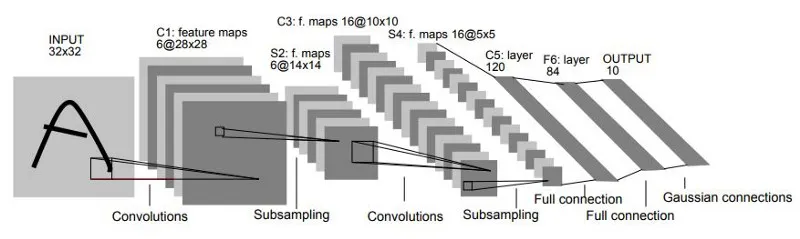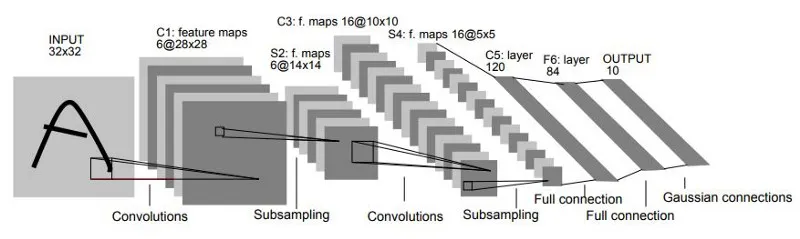

In [65]:
class LeNet5V1(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature = nn.Sequential(
            #1
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2),   # 28*28->32*32-->28*28
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),  # 14*14
            
            #2
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),  # 10*10
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),  # 5*5
            
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16*5*5, out_features=120),
            nn.Tanh(),
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=10),
        )
        
    def forward(self, x):
        return self.classifier(self.feature(x))

model = LeNet5V1()

#### CNN Model Visualize

In [66]:
summary(model=model, 
        input_size=(1, 1, 28, 28), 
        col_width=20,
        col_names=['input_size', 'output_size', 'num_params', 'trainable'], 
        row_settings=['var_names'], 
        verbose=0)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
LeNet5V1 (LeNet5V1)                      [1, 1, 28, 28]       [1, 10]              --                   True
├─Sequential (feature)                   [1, 1, 28, 28]       [1, 16, 5, 5]        --                   True
│    └─Conv2d (0)                        [1, 1, 28, 28]       [1, 6, 28, 28]       156                  True
│    └─Tanh (1)                          [1, 6, 28, 28]       [1, 6, 28, 28]       --                   --
│    └─AvgPool2d (2)                     [1, 6, 28, 28]       [1, 6, 14, 14]       --                   --
│    └─Conv2d (3)                        [1, 6, 14, 14]       [1, 16, 10, 10]      2,416                True
│    └─Tanh (4)                          [1, 16, 10, 10]      [1, 16, 10, 10]      --                   --
│    └─AvgPool2d (5)                     [1, 16, 10, 10]      [1, 16, 5, 5]        --                   --
├─Sequential (classifi

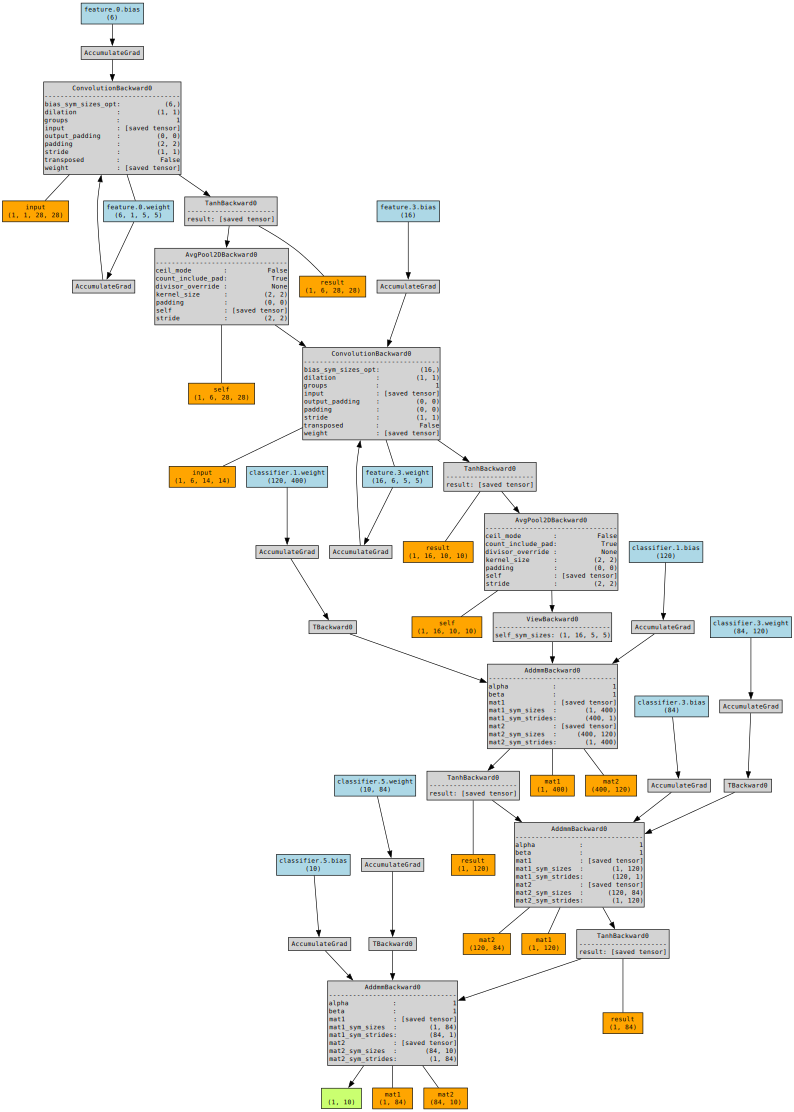

In [67]:
model = LeNet5V1()
x = torch.randn(1, 1, 28, 28)
y = model(x)
graph = make_dot(y, params=dict(model.named_parameters()), show_attrs=True, show_saved=True)
display(graph)

The LeNet5V1 model is a convolutional neural network (CNN) designed for digit classification, closely resembling the original LeNet-5 architecture. It processes 28x28 grayscale images MMIST through a feature extraction stage followed by a classification stage. The feature extractor consists of two convolutional layers (with 6 and 16 filters, respectively) as image and summary above and each layer applied Tanh activation and average pooling to reduce the spatial dimensions from 28x28 to 5x5 while increasing feature depth. The classifier then flattens these features into a 400-unit vector and passes it through three fully connected layers (400→120→84→10) and then we applied the Tanh activations to produce a 10-class output for digit prediction (from 0->9). With 61,706 parameters and a computational complexity of 0.42 million multiply-add operations, the model is lightweight and requiring only 0.30 MB of total memory. All layers are trainable and making it adaptable for optimizing performance on digit recognition tasks as the assignment requirements

#### Setup Loss, Optimizer and Metrics

In [68]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
accuracy = Accuracy(task='multiclass', num_classes=10)

#### CNN Model Build

In [69]:
timestamp = datetime.now().strftime("%Y-%m-%d")
experiment_name = "MNIST"
model_name = "LeNet5V1"
log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
writer = SummaryWriter(log_dir)

# device-agnostic setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

EPOCHS = 12
train_loss_results = []
val_loss_results = []
train_acc_results = []
val_acc_results = []

for epoch in tqdm(range(EPOCHS)):
    train_loss, train_acc = 0.0, 0.0
    model.train()
    
    for X, y in train_dataloader:
        X, y = X.to(device), y.to(device)
        
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        acc = accuracy(y_pred, y)
        train_acc += acc
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    train_loss_results.append(train_loss)
    train_acc_results.append(train_acc)
        
    val_loss, val_acc = 0.0, 0.0
    model.eval()
    with torch.inference_mode():
        for X, y in val_dataloader:
            X, y = X.to(device), y.to(device)
            
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            val_loss += loss.item()
            acc = accuracy(y_pred, y)
            val_acc += acc
            
        val_loss /= len(val_dataloader)
        val_acc /= len(val_dataloader)
        val_loss_results.append(val_loss)
        val_acc_results.append(val_acc)
        
    writer.add_scalars(main_tag="Loss", tag_scalar_dict={"train/loss": train_loss, "val/loss": val_loss}, global_step=epoch)
    writer.add_scalars(main_tag="Accuracy", tag_scalar_dict={"train/acc": train_acc, "val/acc": val_acc}, global_step=epoch)
    
    print(f"Epoch: {epoch}| Train loss: {train_loss: .5f}| Train acc: {train_acc: .5f}| Val loss: {val_loss: .5f}| Val acc: {val_acc: .5f}")

  8%|▊         | 1/12 [00:04<00:52,  4.76s/it]

Epoch: 0| Train loss:  0.20894| Train acc:  0.93987| Val loss:  0.08399| Val acc:  0.97374


 17%|█▋        | 2/12 [00:09<00:49,  4.94s/it]

Epoch: 1| Train loss:  0.07076| Train acc:  0.97840| Val loss:  0.05836| Val acc:  0.98205


 25%|██▌       | 3/12 [00:14<00:45,  5.01s/it]

Epoch: 2| Train loss:  0.04911| Train acc:  0.98515| Val loss:  0.04372| Val acc:  0.98703


 33%|███▎      | 4/12 [00:19<00:39,  4.93s/it]

Epoch: 3| Train loss:  0.04066| Train acc:  0.98674| Val loss:  0.04331| Val acc:  0.98620


 42%|████▏     | 5/12 [00:24<00:34,  4.94s/it]

Epoch: 4| Train loss:  0.03175| Train acc:  0.98998| Val loss:  0.04455| Val acc:  0.98670


 50%|█████     | 6/12 [00:29<00:29,  4.96s/it]

Epoch: 5| Train loss:  0.02648| Train acc:  0.99113| Val loss:  0.03726| Val acc:  0.98886


 58%|█████▊    | 7/12 [00:34<00:24,  4.90s/it]

Epoch: 6| Train loss:  0.02243| Train acc:  0.99289| Val loss:  0.04077| Val acc:  0.98737


 67%|██████▋   | 8/12 [00:39<00:19,  4.86s/it]

Epoch: 7| Train loss:  0.01865| Train acc:  0.99365| Val loss:  0.04520| Val acc:  0.98554


 75%|███████▌  | 9/12 [00:44<00:14,  4.85s/it]

Epoch: 8| Train loss:  0.01841| Train acc:  0.99382| Val loss:  0.04394| Val acc:  0.98787


 83%|████████▎ | 10/12 [00:48<00:09,  4.85s/it]

Epoch: 9| Train loss:  0.01515| Train acc:  0.99508| Val loss:  0.04060| Val acc:  0.98836


 92%|█████████▏| 11/12 [00:53<00:04,  4.83s/it]

Epoch: 10| Train loss:  0.01394| Train acc:  0.99541| Val loss:  0.04037| Val acc:  0.98853


100%|██████████| 12/12 [00:58<00:00,  4.89s/it]

Epoch: 11| Train loss:  0.01455| Train acc:  0.99519| Val loss:  0.03966| Val acc:  0.98903


#### Save and Reload the model to Evaluation

In [70]:
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "lenet5_custom_mnist.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

In [71]:
print(f"Saving the model: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

model_lenet5_v1_mnist_loaded = LeNet5V1()
model_lenet5_v1_mnist_loaded.load_state_dict(torch.load(MODEL_SAVE_PATH))

Saving the model: models\lenet5_custom_mnist.pth


<All keys matched successfully>

### Step 6: Model Evaluation

#### Calculate the Loss and Accuracy on Standard Test Data

In [72]:
test_loss_cnn, test_acc = 0, 0

model_lenet5_v1_mnist_loaded.to(device)
test_loss_results = []
test_acc_results = []

model_lenet5_v1_mnist_loaded.eval()
with torch.inference_mode():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        y_pred = model_lenet5_v1_mnist_loaded(X)
        
        test_loss_cnn += loss_fn(y_pred, y)
        test_acc += accuracy(y_pred, y)
        test_loss_results.append(test_loss_cnn)
        test_acc_results.append(test_acc)
        
    test_loss_cnn /= len(test_dataloader)
    test_acc /= len(test_dataloader)

print(f"Test loss (Standard Test Dataset): {test_loss_cnn: .5f}| Test acc(Standard Test Dataset): {test_acc: .5f}")

Test loss (Standard Test Dataset):  0.04368| Test acc(Standard Test Dataset):  0.98842


#### Visualize the Loss and Accuracy through the training, validating and test process on the Standard Test Dataset

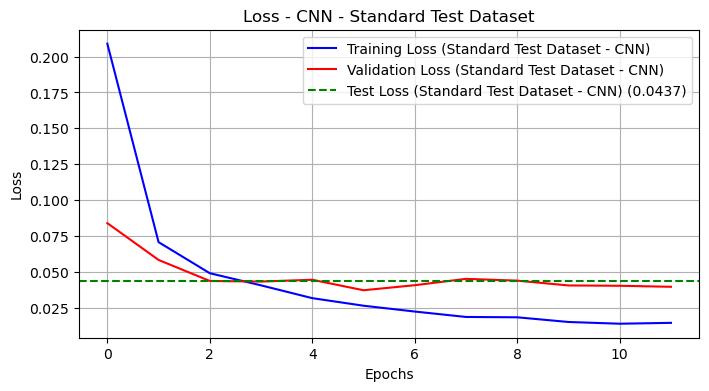

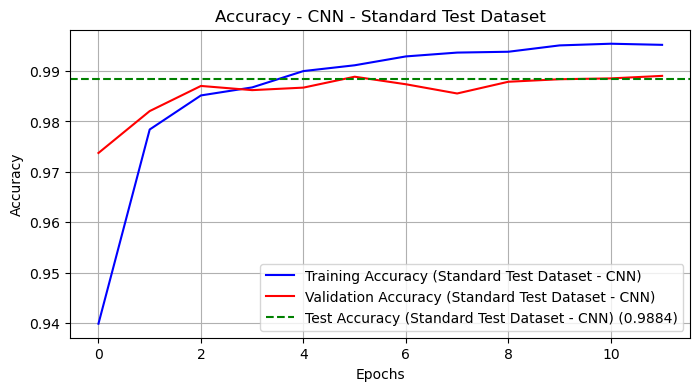

In [73]:
epochs = range(len(train_loss_results))

plt.figure(figsize=(8, 4))
plt.plot(epochs, train_loss_results, 'b-', label='Training Loss (Standard Test Dataset - CNN)')
plt.plot(epochs, val_loss_results, 'r-', label='Validation Loss (Standard Test Dataset - CNN)')
plt.axhline(y=test_loss_cnn, color='g', linestyle='--', label=f'Test Loss (Standard Test Dataset - CNN) ({test_loss_cnn:.4f})')
plt.title('Loss - CNN - Standard Test Dataset')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(epochs, train_acc_results, 'b-', label='Training Accuracy (Standard Test Dataset - CNN)')
plt.plot(epochs, val_acc_results, 'r-', label='Validation Accuracy (Standard Test Dataset - CNN)')
plt.axhline(y=test_acc, color='g', linestyle='--', label=f'Test Accuracy (Standard Test Dataset - CNN) ({test_acc:.4f})')
plt.title('Accuracy - CNN - Standard Test Dataset')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

#### Calculate the Loss and Accuracy on Noisy Data

In [74]:
test_loss_noisy, test_acc_noisy = 0, 0

model_lenet5_v1_mnist_loaded.to(device)
test_loss_noisy_results = []
test_acc_noisy_results = []

model_lenet5_v1_mnist_loaded.eval()
with torch.inference_mode():
    for X, y in test_dataloader_noisy:
        X, y = X.to(device), y.to(device)
        y_pred = model_lenet5_v1_mnist_loaded(X)
        
        test_loss_noisy += loss_fn(y_pred, y)
        test_acc_noisy += accuracy(y_pred, y)
        test_loss_noisy_results.append(test_loss)
        test_acc_noisy_results.append(test_acc)
        
    test_loss_noisy /= len(test_dataloader_noisy)
    test_acc_noisy /= len(test_dataloader_noisy)

print(f"Test loss (Noisy Data): {test_loss_noisy: .5f}| Test acc(Noisy Data): {test_acc_noisy: .5f}")

Test loss (Noisy Data):  4.93012| Test acc(Noisy Data):  0.43900


#### Visualize the Loss and Accuracy through the training, validating and test process on the Noisy Test Dataset

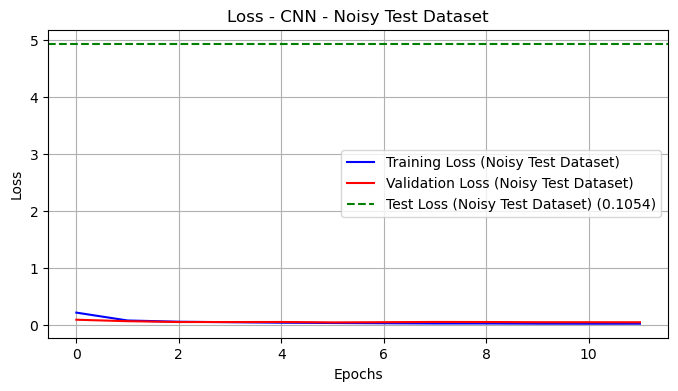

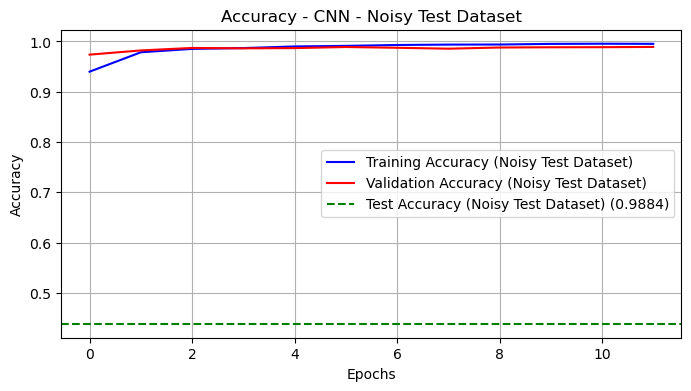

In [75]:
plt.figure(figsize=(8, 4))
plt.plot(epochs, train_loss_results, 'b-', label='Training Loss (Noisy Test Dataset)')
plt.plot(epochs, val_loss_results, 'r-', label='Validation Loss (Noisy Test Dataset)')
plt.axhline(y=test_loss_noisy, color='g', linestyle='--', label=f'Test Loss (Noisy Test Dataset) ({test_loss:.4f})')
plt.title('Loss - CNN - Noisy Test Dataset')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(epochs, train_acc_results, 'b-', label='Training Accuracy (Noisy Test Dataset)')
plt.plot(epochs, val_acc_results, 'r-', label='Validation Accuracy (Noisy Test Dataset)')
plt.axhline(y=test_acc_noisy, color='g', linestyle='--', label=f'Test Accuracy (Noisy Test Dataset) ({test_acc:.4f})')
plt.title('Accuracy - CNN - Noisy Test Dataset')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

#### Predict 12 Random images with their labels Standard Test Dataset

C:\Users\ignat\AppData\Local\Temp\ipykernel_30592\1477439287.py:18: UserWarning: The figure layout has changed to tight
  plt.tight_layout();


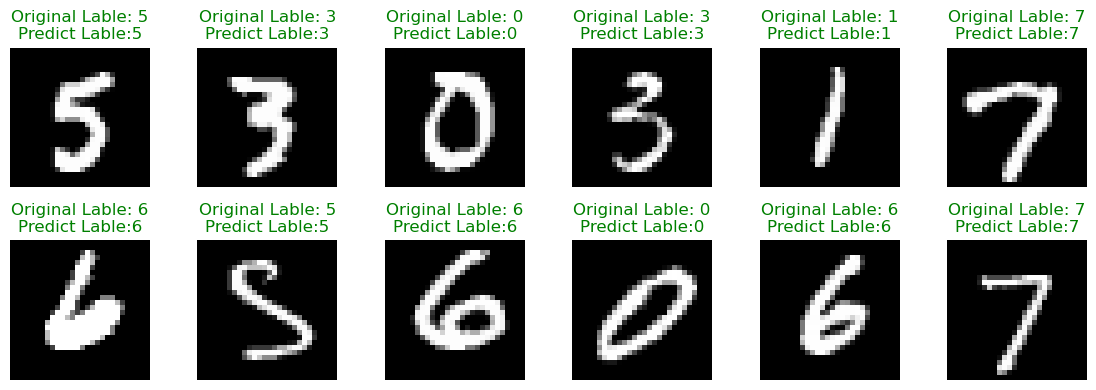

In [76]:
fig = plt.figure(figsize=(12, 4))

rows, cols = 2, 6
for i in range(1, (rows * cols) + 1):
    random_idx = torch.randint(0, len(test_dataset), size=[1]).item()
    img, label_gt = test_dataset[random_idx]
    img_temp = img.unsqueeze(dim=0).to(device)
    # print(img.shape)
    label_pred = torch.argmax(model_lenet5_v1_mnist_loaded(img_temp))
    fig.add_subplot(rows, cols, i)
    img = img.permute(1, 2, 0)
    plt.imshow(img, cmap='gray')
    if label_pred == label_gt:
        plt.title(f"Original Lable: {label_gt}\nPredict Lable:{label_pred}", color='g')
    else:
        plt.title(f"Original Lable: {label_gt}\nPredict Lable:{label_pred}", color='r')
    plt.axis(False)
    plt.tight_layout();

#### Predict 12 Random images with their labels Noisy Test Dataset

C:\Users\ignat\AppData\Local\Temp\ipykernel_30592\2806659185.py:18: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


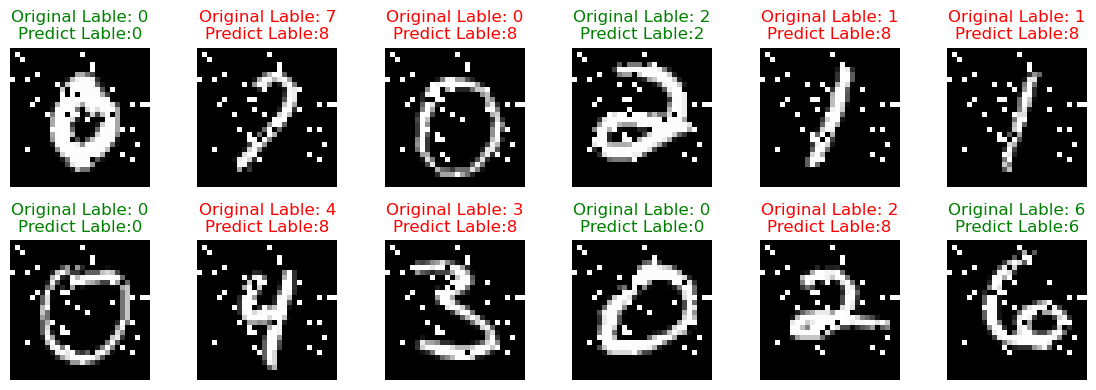

In [77]:
fig = plt.figure(figsize=(12, 4))

rows, cols = 2, 6
for i in range(1, (rows * cols) + 1):
    random_idx = torch.randint(0, len(test_dataset_noisy), size=[1]).item()
    img, label_gt = test_dataset_noisy[random_idx]
    img_temp = img.unsqueeze(dim=0).to(device)
    # print(img.shape)
    label_pred = torch.argmax(model_lenet5_v1_mnist_loaded(img_temp))
    fig.add_subplot(rows, cols, i)
    img = img.permute(1, 2, 0)
    plt.imshow(img, cmap='gray')
    if label_pred == label_gt:
        plt.title(f"Original Lable: {label_gt}\nPredict Lable:{label_pred}", color='g')
    else:
        plt.title(f"Original Lable: {label_gt}\nPredict Lable:{label_pred}", color='r')
    plt.axis(False)
    plt.tight_layout()

### Step 7: Model Comparison 

Based on your results, compare the FNN and CNN models, and write your final conclusion about the
performance of both models.

=== FNN Evaluation ===
Original Test - Loss: 0.1054, Accuracy: 0.9749
Noisy Test    - Loss: 0.3220, Accuracy: 0.9157

=== CNN Evaluation ===
Original Test - Loss: 0.0437, Accuracy: 0.9884
Noisy Test    - Loss: 4.9301, Accuracy: 0.4390



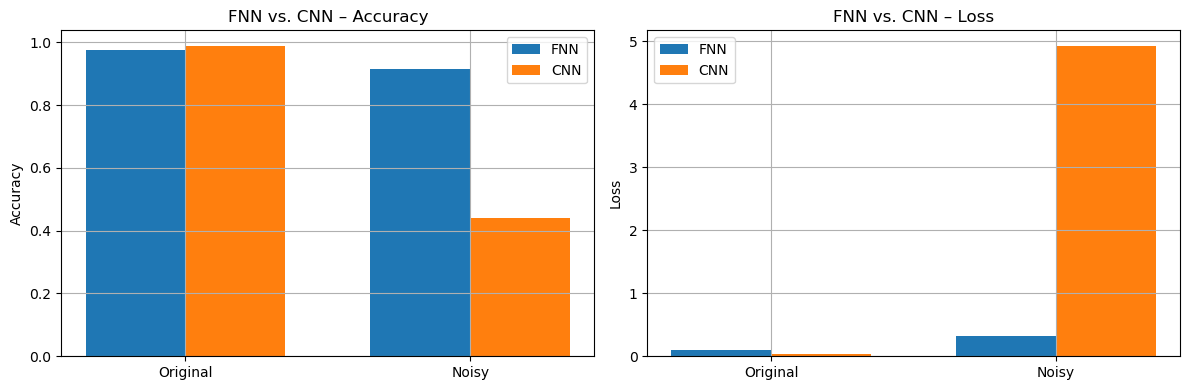

In [81]:
# 1. Print the final metrics
print("=== FNN Evaluation ===")
print(f"Original Test - Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}")
print(f"Noisy Test    - Loss: {noisy_test_loss:.4f}, Accuracy: {noisy_test_accuracy:.4f}\n")

print("=== CNN Evaluation ===")
print(f"Original Test - Loss: {test_loss_cnn:.4f}, Accuracy: {test_acc:.4f}")
print(f"Noisy Test    - Loss: {test_loss_noisy:.4f}, Accuracy: {test_acc_noisy:.4f}\n")

# 2. Prepare data for visualization
labels = ["Original", "Noisy"]
fnn_scores = [test_accuracy, noisy_test_accuracy]
cnn_scores = [test_acc, test_acc_noisy]
fnn_losses = [test_loss, noisy_test_loss]
cnn_losses = [test_loss_cnn, test_loss_noisy]  

x = np.arange(len(labels))
width = 0.35

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Accuracy comparison
ax1.bar(x - width/2, fnn_scores, width, label='FNN')
ax1.bar(x + width/2, cnn_scores, width, label='CNN')
ax1.set_ylabel('Accuracy')
ax1.set_title('FNN vs. CNN – Accuracy')
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.legend()
ax1.grid(True)

ax2.bar(x - width/2, fnn_losses, width, label='FNN')
ax2.bar(x + width/2, cnn_losses, width, label='CNN')
ax2.set_ylabel('Loss')
ax2.set_title('FNN vs. CNN – Loss')
ax2.set_xticks(x)
ax2.set_xticklabels(labels)
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


#### Discussion
***
Convolutional Neural Networks (CNN) and Fully Connected Neural Networks (FNN) were both implemented for handwritten digit classification using the MNIST dataset. First, the raw images were normalized to a [0, 1] range and reshaped for each model. The data was then divided into training, validation, and test sets. To further analyze both models, a portion of the test data was corrupted with random noise, and both models were evaluated on this noisy data.

Results for the FNN showed an original test loss of around 0.1 with an accuracy of approximately 0.97, while the noisy test loss increased, and accuracy dropped but remained relatively high (above 0.91). In contrast, the CNN (LeNet5 architecture) achieved slightly higher accuracy on the clean test set and showed better resilience to noise. Feed forward networks are networks which feed data forward with no feedback loops. Networks that have feedback loops are recurrent neural networks. The results were expected because CNNs apply kernels (convolution/convolutional filters), drasticly reducing the number of parameters compared to fully connected layers and extracting local features more effectively. This makes CNN models very useful in problems where data have an 'image' like structures, unlike FNNs that rely on dense layers. In addition, the performance drop in both models on noisy data demonstrates the importance of applying noise handling strategies when using a new dataset during data preprocessing, especially considering that in real world data such noise is very common. We assume that CNN models can also be more sensitive to noise as we can seIn conclusion, the results show the advantages of CNNs for image classification tasks
***